## 003 : 3-Hidden Layer CNN with Data Augmentation

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
from keras.models import load_model
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

/home/che/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../41157150'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [5]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [6]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [7]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_3layer_v2_2class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 48)        27696     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       55424     
__________

None

In [8]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 1 2 1 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 1 2 2
 2 1 2 2 2 1 1 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 1 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 1 2 2] [1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 2 2 2 2
 1 1 1 2 1 1 2 1 1 1 1 2 1 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1
 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2] [1 2 2 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 1 1 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2 1 1
 1 1 1 1 2 1 2 2 2 1 2 1 1 2 2 2 1 1 2 1 2 2 2 1 2 2 2 1 1 2 1 2 2 1 1 2 1
 2 2 2 1 2 1 1 1 2 2 2 1 2 1 1 2 2 1 1 1 2 1 2 1 2 2]


In [9]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

epochs2 = 7
batch_size2 = 64

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=45,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                     # Randomly zoom image 
        width_shift_range=0.15,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size2),
                              epochs = epochs2, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer(), cnn_models.early_stopping()])

Epoch 1/7
2812/2812 [==============================] - 351s 125ms/step - loss: 0.1729 - acc: 0.9368 - val_loss: 0.9357 - val_acc: 0.8945
Epoch 2/7
2812/2812 [==============================] - 346s 123ms/step - loss: 0.1122 - acc: 0.9565 - val_loss: 0.9119 - val_acc: 0.8512
Epoch 3/7
2812/2812 [==============================] - 346s 123ms/step - loss: 0.0747 - acc: 0.9711 - val_loss: 1.2675 - val_acc: 0.8988
Epoch 4/7
2812/2812 [==============================] - 346s 123ms/step - loss: 0.0569 - acc: 0.9800 - val_loss: 1.3609 - val_acc: 0.8945
Epoch 00004: early stopping


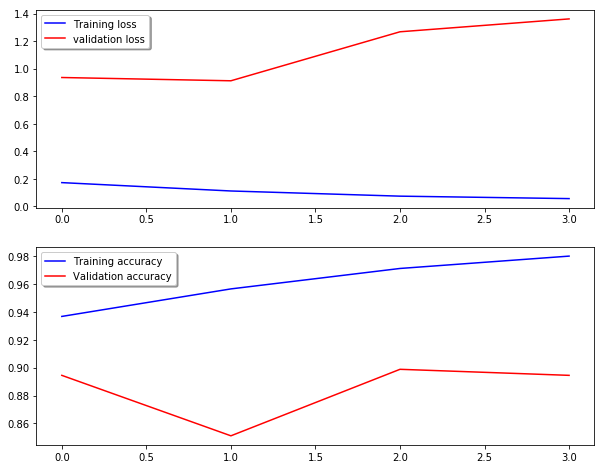

Precision (specificity): 71.182%
Recall (sensitivity): 69.491%
Accuracy: 69.167%
F1: 68.632%


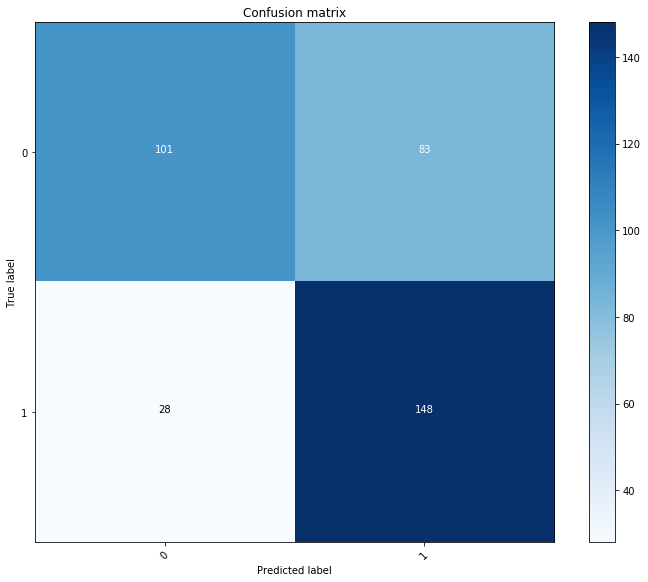

In [12]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [13]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

mdi-945f5ac6 [0.9071198  0.09362894] 0
mdi-df9a656f [0.9278051  0.07472766] 1
mdi-5e3d3832 [0.72544193 0.27417025] 0
mdi-1061cc91 [8.682046e-04 9.991666e-01] 1
mdi-b731a91f [0.00604811 0.99388087] 0
mdi-9abd4637 [1.246109e-04 9.998680e-01] 1


In [14]:
model.save('model_003_data_aug.h5')